**Author:** Akhmetkin Oleg \
**Group:** 306

# Aho-Corasick and Commentz-Walter algorithms

## Aho-Corasick

### Implementation

In [1]:
from collections import defaultdict
 

class AhoCorasick:
    def __init__(self, words):
        self.max_states = sum([len(word) for word in words])
        self.max_characters = 26
        self.out = [0]*(self.max_states+1)
        self.fail = [-1]*(self.max_states+1)
        self.goto = [[-1]*self.max_characters for _ in range(self.max_states+1)]
           
        self.words = words
        self.states_count = self.__build_matching_machine()
 
 
    def __build_matching_machine(self):
        k = len(self.words)
        states = 1
 
        for i in range(k):
            word = self.words[i]
            current_state = 0
 
            for character in word:
                ch = ord(character) - 97 # Ascii value of 'a' = 97
 
                if self.goto[current_state][ch] == -1:
                    self.goto[current_state][ch] = states
                    states += 1
 
                current_state = self.goto[current_state][ch]
 
            self.out[current_state] |= (1<<i)
 
        for ch in range(self.max_characters):
            if self.goto[0][ch] == -1:
                self.goto[0][ch] = 0
        
        queue = []
        
        for ch in range(self.max_characters):
            if self.goto[0][ch] != 0:
                self.fail[self.goto[0][ch]] = 0
                queue.append(self.goto[0][ch])
 
        while queue:
            state = queue.pop(0)
 
            for ch in range(self.max_characters):
                if self.goto[state][ch] != -1:
                    failure = self.fail[state]
 
                    while self.goto[failure][ch] == -1:
                        failure = self.fail[failure]
                     
                    failure = self.goto[failure][ch]
                    self.fail[self.goto[state][ch]] = failure
 
                    self.out[self.goto[state][ch]] |= self.out[failure]

                    queue.append(self.goto[state][ch])
         
        return states
 
 
    def __find_next_state(self, current_state, next_input):
        answer = current_state
        ch = ord(next_input) - 97 # Ascii value of 'a' is 97
 
        while self.goto[answer][ch] == -1:
            answer = self.fail[answer]
 
        return self.goto[answer][ch]
 
 
    def search_words(self, text):
        current_state = 0
        result = defaultdict(list)

        for i in range(len(text)):
            current_state = self.__find_next_state(current_state, text[i])

            if self.out[current_state] == 0: continue

            for j in range(len(self.words)):
                if (self.out[current_state] & (1<<j)) > 0:
                    word = self.words[j]

                    result[word].append(i-len(word)+1)

        return result

### Usage example

In [43]:
words = ['he', 'she', 'hers', 'his']
text = 'ahishersaaaahe'

aho_chorasick = AhoCorasick(words)
result = aho_chorasick.search_words(text)
list(result.items())

[('his', [1]), ('he', [4, 12]), ('she', [3]), ('hers', [4])]

## Commentz-Walter

### Implementation

In [3]:
class TrieNode:
    def __init__(self, char):
        self.char = char
        self.children = {}
        self.failure_link = None
        self.output_link = []
        

class CommentzWalter:
    def __init__(self):
        self.root = TrieNode(None)
    
    def add_word(self, word):
        node = self.root
        for char in word:
            if char not in node.children:
                node.children[char] = TrieNode(char)
            node = node.children[char]
        node.output_link.append(word)
    
    def build_matching_machine(self):
        queue = []
        
        for child in self.root.children.values():
            queue.append(child)
            child.failure_link = self.root
        
        while queue:
            current_node = queue.pop(0)
            
            for char, child in current_node.children.items():
                queue.append(child)
                failure_node = current_node.failure_link
                
                while failure_node and char not in failure_node.children:
                    failure_node = failure_node.failure_link
                
                child.failure_link = failure_node.children[char] if failure_node else self.root
                
                child.output_link.extend(child.failure_link.output_link)
    
    def search(self, text):
        result = []
        current_node = self.root
        
        for i, char in enumerate(text):
            while current_node and char not in current_node.children:
                current_node = current_node.failure_link
            
            if not current_node:
                current_node = self.root
                continue
            
            current_node = current_node.children[char]
            
            if current_node.output_link:
                result.extend((i - len(word) + 1, word) for word in current_node.output_link)
        
        return result

### Usage example

In [44]:
words = ['he', 'she', 'hers', 'his']
text = 'ahishersaaaahe'

cw = CommentzWalter()

for word in words: 
    cw.add_word(word)

cw.build_matching_machine()

result = cw.search(text)
result

[(1, 'his'), (3, 'she'), (4, 'he'), (4, 'hers'), (12, 'he')]

## Text generation for comparison

In [5]:
from random import choice, choices, randint
from numpy.random import rand
import string

In [6]:
ALPHABET = string.ascii_lowercase


def generate_text_and_words(length=10**5, count=100, max_pattern_len=5, unique_words_count=100):  
    words = [''.join(choices(ALPHABET, k=randint(2, max_pattern_len))) for _ in range(unique_words_count)]
    words = list(set(words))
    text = choices(ALPHABET, k=length)
    
    for _ in range(count):
        word = choice(words)
        l = len(word)
        idx = randint(0, length-l-1)
        text[idx:idx+l] = list(word)
    
    return { 'words': words, 'text': ''.join(text) }

## Benchmarking

In [67]:
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
def benchmark(words, text, verbose=False):
    start = time.time()
    aho_chorasick = AhoCorasick(words)
    result = aho_chorasick.search_words(text)
    end = time.time()
    ac_time = end - start
    
    if verbose:
        print(f'Aho-Corasick:    {ac_time} sec')
        print('matches count:  ', sum([len(m) for m in list(result.values())]))


    start = time.time()
    cw = CommentzWalter()

    for word in words: 
        cw.add_word(word)

    cw.build_matching_machine()
    result = cw.search(text)
    end = time.time()
    cw_time = end - start
    
    if verbose:
        print(f'Commentz-Walter: {cw_time} sec')
        print('matches count:  ', len(result))
    
    return ac_time, cw_time

In [80]:
from IPython.display import clear_output
from tqdm import tqdm

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:35<00:00,  7.77s/it]


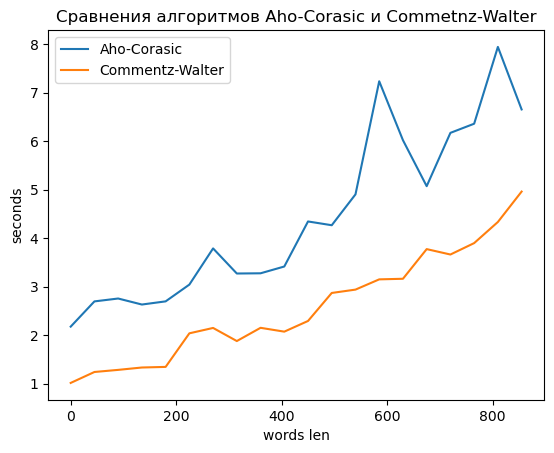

In [81]:
TEXT_LENGTH = 2 * 10**6
STEPS = range(0, 900, 45)

times = {
    'AC': [],
    'CW': [],
}

for k in tqdm(STEPS):
    print(f'benchmark for k: {k}')
    count = 100 + k // 2
    mpl = 3 + k
    uwc = 10 + k // 25
    ex = generate_text_and_words(length=TEXT_LENGTH, count=count, max_pattern_len=mpl, unique_words_count=uwc)
    
    words, text = ex.values()
    ac, cw = benchmark(words, text)
    
    times['AC'].append(ac)
    times['CW'].append(cw)
    
    clear_output(wait=True)

plt.plot(STEPS, times['AC'], label='Aho-Corasic')
plt.plot(STEPS, times['CW'], label='Commentz-Walter')
plt.legend()
plt.title('Сравнение алгоритмов Aho-Corasic и Commetnz-Walter')
plt.xlabel('words len')
plt.ylabel('seconds')
None